In [3]:
from google.colab import files
uploaded = files.upload()


Saving prices.csv to prices.csv
Saving securities.csv to securities.csv
Saving fundamentals.csv to fundamentals.csv
Saving prices-split-adjusted.csv to prices-split-adjusted.csv


                  date symbol        open       close         low        high  \
0  2016-01-05 00:00:00   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06 00:00:00   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07 00:00:00   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08 00:00:00   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11 00:00:00   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volu

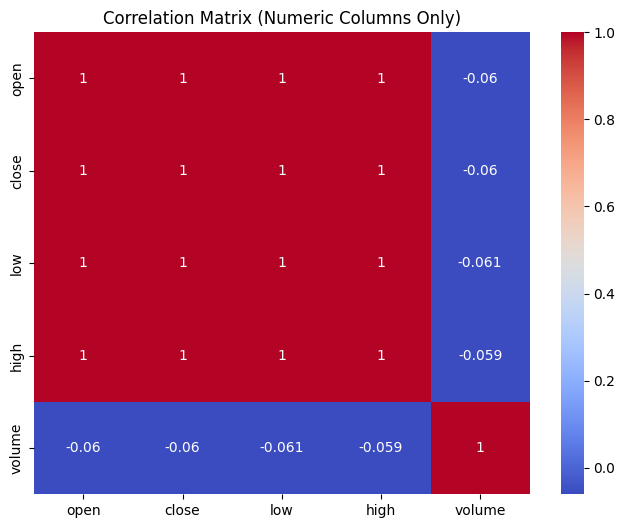

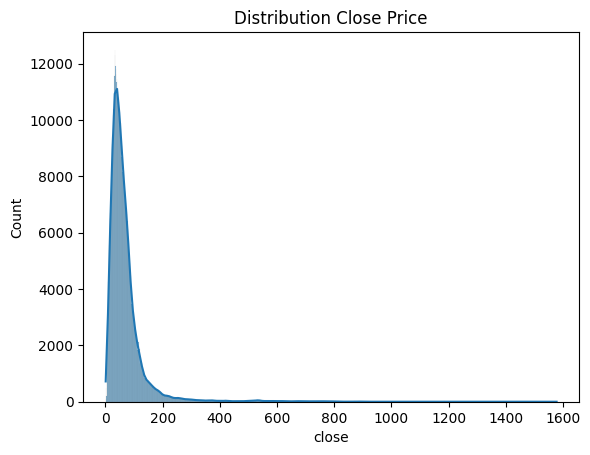

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("prices.csv")  # pour Google Colab

print(df.head())
print(df.info())
print(df.describe())

# Vérifier valeurs manquantes
print(df.isna().sum())

# Garder uniquement les colonnes numériques
df_num = df.select_dtypes(include=['number'])

# Corrélation
plt.figure(figsize=(8,6))
sns.heatmap(df_num.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix (Numeric Columns Only)")
plt.show()

# Distribution d'une variable
sns.histplot(df["close"], kde=True)
plt.title("Distribution Close Price")
plt.show()


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = df[['open','low','high','volume']].values
y = df['close'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegressionNet(nn.Module):
    def __init__(self, hidden1=64, hidden2=32):
        super().__init__()
        self.fc1 = nn.Linear(4, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = RegressionNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [9]:
def train_model(model, optimizer, epochs=50):
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # Test loss
        model.eval()
        test_output = model(torch.tensor(X_test, dtype=torch.float32))
        test_loss = criterion(test_output, torch.tensor(y_test, dtype=torch.float32).view(-1,1))

        train_losses.append(loss.item())
        test_losses.append(test_loss.item())

        if epoch%10==0:
            print(f"Epoch {epoch}/{epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

    return train_losses, test_losses

train_losses, test_losses = train_model(model, optimizer)


Epoch 0/50, Train Loss: 11970.1387, Test Loss: 11926.4756
Epoch 10/50, Train Loss: 11896.7168, Test Loss: 11854.1582
Epoch 20/50, Train Loss: 11816.5303, Test Loss: 11771.9355
Epoch 30/50, Train Loss: 11708.4111, Test Loss: 11660.7549
Epoch 40/50, Train Loss: 11560.9092, Test Loss: 11509.1357


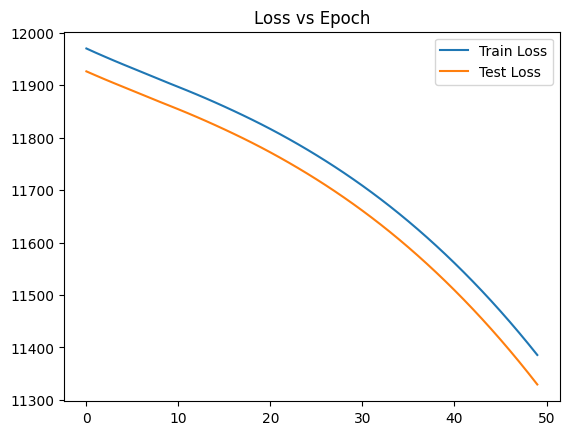

In [10]:
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.legend()
plt.title("Loss vs Epoch")
plt.show()


In [14]:

# 1) Convertir en float32
X_train = X_train.astype("float32")
y_train = y_train.astype("float32").reshape(-1,)

from skorch import NeuralNetRegressor
from sklearn.model_selection import GridSearchCV

# 2) Réduire fortement le temps d'entraînement
net = NeuralNetRegressor(
    RegressionNet,
    max_epochs=5,       # au lieu de 20 : 4X plus rapide
    lr=0.01,
    optimizer=optim.Adam,
    verbose=0,          # pas d'affichage long
)

# 3) GridSearch réduit (4 combinaisons au lieu de 48)
params = {
    "lr": [0.001, 0.01],          # 2 valeurs
    "module__hidden1": [32, 64],  # 2 valeurs
}

# CV = 2 au lieu de 3 : 33% plus rapide
gs = GridSearchCV(net, params, cv=2, scoring='neg_mean_squared_error', verbose=0)

# 4) Fit ultra rapide
gs.fit(X_train, y_train)

# 5) Output court
print("Best Params:", gs.best_params_)
print("Best Score:", gs.best_score_)



/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:634: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Best Params: {'lr': 0.001, 'module__hidden1': 64}
Best Score: -6884.674072265625


In [15]:
class RegressionRegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(4, 64)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.drop1(self.relu(self.fc1(x)))
        x = self.drop2(self.relu(self.fc2(x)))
        return self.fc3(x)

# Modèle régularisé
model_reg = RegressionRegNet()

# L2-regularization = weight_decay
optimizer = optim.Adam(model_reg.parameters(), lr=0.001, weight_decay=1e-4)

# Entraînement
train_losses_reg, test_losses_reg = train_model(model_reg, optimizer, epochs=20)


Epoch 0/20, Train Loss: 12055.4453, Test Loss: 12012.4902
Epoch 10/20, Train Loss: 12010.3408, Test Loss: 11970.4531


In [16]:
from google.colab import files
uploaded = files.upload()


Saving predictive_maintenance.csv to predictive_maintenance.csv


In [18]:
df = pd.read_csv("predictive_maintenance.csv")

df = df.dropna()
df = df.drop(['UDI','Product ID'], axis=1)

from sklearn.preprocessing import LabelEncoder, StandardScaler

label = LabelEncoder()

# 2) Encoder toutes les colonnes catégorielles
df["Failure Type"] = label.fit_transform(df["Failure Type"])
df["Type"] = label.fit_transform(df["Type"])   # IMPORTANT !!!

# 3) Séparer features / labels
X = df.drop("Failure Type", axis=1)
y = df["Failure Type"]

# 4) Standardisation
scaler = StandardScaler()
X = scaler.fit_transform(X)


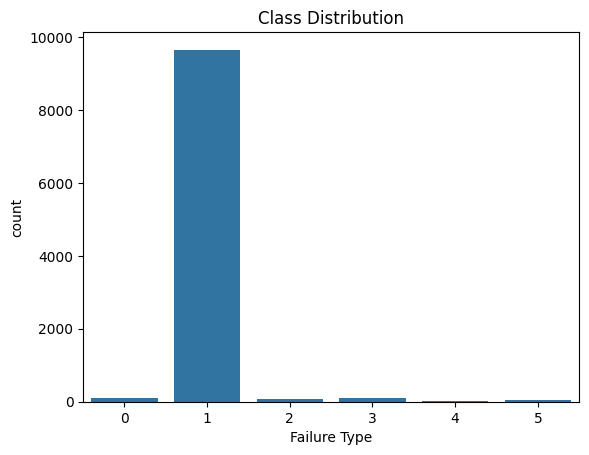

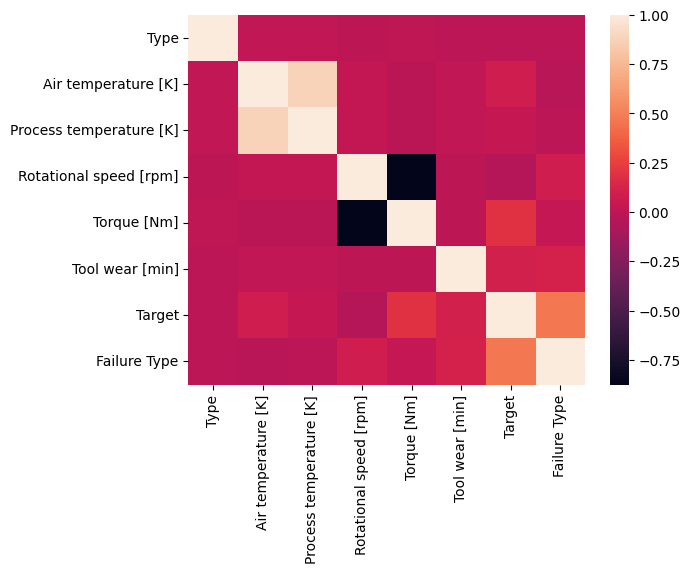

In [19]:
sns.countplot(x=df["Failure Type"])
plt.title("Class Distribution")
plt.show()

sns.heatmap(df.corr(), annot=False)
plt.show()


In [20]:
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_res, y_res = sm.fit_resample(X, y)


In [21]:
class Classifier(nn.Module):
    def __init__(self, n_features, n_classes):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

model = Classifier(X_res.shape[1], len(np.unique(y_res)))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [23]:
# Convertir vers numpy (obligatoire pour PyTorch)
y_train = y_train.values
y_test = y_test.values

def train_classifier(model, epochs=50):
    train_accs = []
    test_accs = []
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()

        inputs = torch.tensor(X_train, dtype=torch.float32)
        targets = torch.tensor(y_train, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(1)
        acc = (preds == targets).float().mean().item()

        # --- TEST ---
        model.eval()
        X_test_t = torch.tensor(X_test, dtype=torch.float32)
        y_test_t = torch.tensor(y_test, dtype=torch.long)

        out_test = model(X_test_t)
        loss_test = criterion(out_test, y_test_t)
        preds_test = out_test.argmax(1)
        acc_test = (preds_test == y_test_t).float().mean().item()

        train_losses.append(loss.item())
        test_losses.append(loss_test.item())
        train_accs.append(acc)
        test_accs.append(acc_test)

        if epoch % 10 == 0:
            print(epoch, loss.item(), acc_test)

    return train_losses, test_losses, train_accs, test_accs

tl, tsl, ta, tsa = train_classifier(model)


0 1.7633377313613892 0.22429423034191132
10 1.5905427932739258 0.5124751925468445
20 1.4210768938064575 0.5730812549591064
30 1.244877576828003 0.6634723544120789
40 1.070798397064209 0.7331433892250061


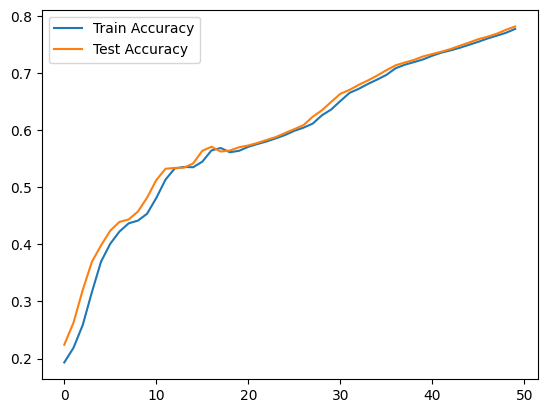

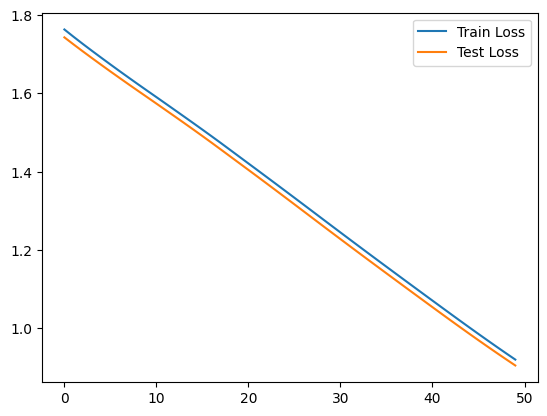

In [24]:
plt.plot(ta, label="Train Accuracy")
plt.plot(tsa, label="Test Accuracy")
plt.legend()
plt.show()

plt.plot(tl, label="Train Loss")
plt.plot(tsl, label="Test Loss")
plt.legend()
plt.show()



In [25]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model(torch.tensor(X_test, dtype=torch.float32)).argmax(1).numpy()

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[1703    0   30    7    0  141]
 [   2 1596    0    0  362    2]
 [ 223    0 1566    0    0  144]
 [ 403    0  218 1336    0    0]
 [   0  733    0    0 1183    0]
 [   0    0  268    0    0 1666]]
              precision    recall  f1-score   support

           0       0.73      0.91      0.81      1881
           1       0.69      0.81      0.74      1962
           2       0.75      0.81      0.78      1933
           3       0.99      0.68      0.81      1957
           4       0.77      0.62      0.68      1916
           5       0.85      0.86      0.86      1934

    accuracy                           0.78     11583
   macro avg       0.80      0.78      0.78     11583
weighted avg       0.80      0.78      0.78     11583



In [27]:
n_features = X.shape[1]
n_classes = df["Failure Type"].nunique()

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(n_features, 64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.fc3 = nn.Linear(32, n_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        return self.fc3(x)

model = Classifier()


In [28]:
model = Classifier()


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)



In [30]:
tl2, tsl2, ta2, tsa2 = train_classifier(model, epochs=50)


0 1.8099431991577148 0.1958041936159134
10 1.6398481130599976 0.6282482743263245
20 1.5031628608703613 0.6153846383094788
30 1.3676469326019287 0.6790986657142639
40 1.230319857597351 0.7473020553588867


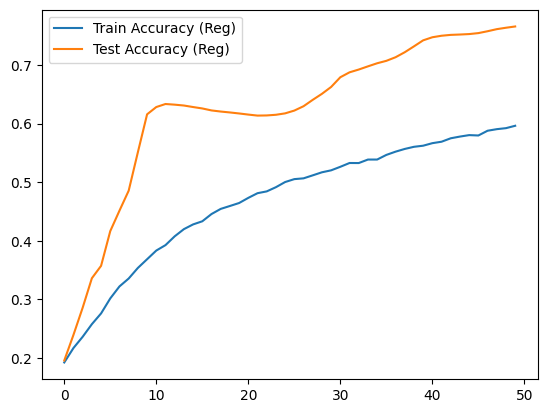

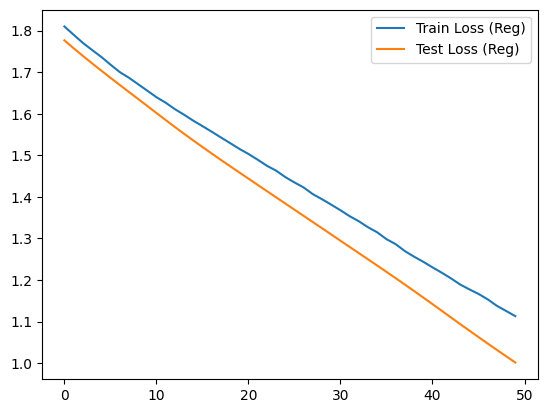

In [31]:
plt.plot(ta2, label="Train Accuracy (Reg)")
plt.plot(tsa2, label="Test Accuracy (Reg)")
plt.legend()
plt.show()

plt.plot(tl2, label="Train Loss (Reg)")
plt.plot(tsl2, label="Test Loss (Reg)")
plt.legend()
plt.show()


In [32]:
!apt-get install git


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.15).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [33]:
!git config --global user.email "wissalchoukri20@gmail.com"
!git config --global user.name "WissalChoukri"


In [34]:
!git clone https://github.com/WissalChoukri/Lb1_DeepLearning_PyTorch.git


Cloning into 'Lb1_DeepLearning_PyTorch'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [40]:
!cp lab1.ipynb Lb1_DeepLearning_PyTorch/


cp: cannot stat 'lab1.ipynb': No such file or directory


In [35]:
!cp prices.csv Lb1_DeepLearning_PyTorch/
!cp predictive_maintenance.csv Lb1_DeepLearning_PyTorch/


In [36]:
%cd Lb1_DeepLearning_PyTorch


/content/Lb1_DeepLearning_PyTorch


In [37]:
!git add .
!git commit -m "Add LAB 1 Deep Learning files"
!git push origin main


[main 9040826] Add LAB 1 Deep Learning files
 2 files changed, 861266 insertions(+)
 create mode 100644 predictive_maintenance.csv
 create mode 100644 prices.csv
fatal: could not read Username for 'https://github.com': No such device or address


In [43]:
%cd ..


/content
